# Elastic Collision Simulation

## Theoretical Foundation

An **elastic collision** is a collision in which both momentum and kinetic energy are conserved. This is an idealized scenario that closely approximates collisions between hard objects like billiard balls or atomic particles.

### Conservation Laws

For a system of two particles undergoing an elastic collision, we have two fundamental conservation laws:

**1. Conservation of Momentum:**

$$m_1 \vec{v}_{1i} + m_2 \vec{v}_{2i} = m_1 \vec{v}_{1f} + m_2 \vec{v}_{2f}$$

**2. Conservation of Kinetic Energy:**

$$\frac{1}{2}m_1 v_{1i}^2 + \frac{1}{2}m_2 v_{2i}^2 = \frac{1}{2}m_1 v_{1f}^2 + \frac{1}{2}m_2 v_{2f}^2$$

### One-Dimensional Elastic Collision

For a head-on collision in one dimension, solving the conservation equations yields the final velocities:

$$v_{1f} = \frac{(m_1 - m_2)v_{1i} + 2m_2 v_{2i}}{m_1 + m_2}$$

$$v_{2f} = \frac{(m_2 - m_1)v_{2i} + 2m_1 v_{1i}}{m_1 + m_2}$$

### Two-Dimensional Elastic Collision

For 2D collisions between spherical objects, we decompose the velocities along the collision normal $\hat{n}$ (the line connecting the centers at impact) and the tangential direction $\hat{t}$.

The velocity components along the collision normal are exchanged according to the 1D formulas, while tangential components remain unchanged:

$$v_{1n,f} = \frac{(m_1 - m_2)v_{1n,i} + 2m_2 v_{2n,i}}{m_1 + m_2}$$

$$v_{2n,f} = \frac{(m_2 - m_1)v_{2n,i} + 2m_1 v_{1n,i}}{m_1 + m_2}$$

$$v_{1t,f} = v_{1t,i}, \quad v_{2t,f} = v_{2t,i}$$

### Coefficient of Restitution

The coefficient of restitution $e$ characterizes the elasticity of a collision:

$$e = \frac{|v_{2f} - v_{1f}|}{|v_{1i} - v_{2i}|}$$

For a perfectly elastic collision, $e = 1$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
np.random.seed(42)

## Simulation Implementation

We implement a particle-based simulation with the following features:
- Multiple particles with different masses and radii
- 2D elastic collisions between particles
- Elastic collisions with boundary walls
- Conservation verification

In [2]:
class Particle:
    """Represents a circular particle with position, velocity, mass, and radius."""
    
    def __init__(self, x, y, vx, vy, mass, radius, color='blue'):
        self.pos = np.array([x, y], dtype=float)
        self.vel = np.array([vx, vy], dtype=float)
        self.mass = mass
        self.radius = radius
        self.color = color
    
    def kinetic_energy(self):
        """Calculate kinetic energy: KE = (1/2)mv^2"""
        return 0.5 * self.mass * np.dot(self.vel, self.vel)
    
    def momentum(self):
        """Calculate momentum: p = mv"""
        return self.mass * self.vel
    
    def update_position(self, dt):
        """Update position based on velocity."""
        self.pos += self.vel * dt

In [3]:
def elastic_collision_2d(p1, p2):
    """
    Handle elastic collision between two particles in 2D.
    
    Uses the vector formulation for 2D elastic collisions.
    """
    # Vector from p1 to p2
    delta_pos = p2.pos - p1.pos
    distance = np.linalg.norm(delta_pos)
    
    # Check if collision occurred
    if distance >= p1.radius + p2.radius:
        return False
    
    # Normal vector (collision axis)
    if distance == 0:
        # Particles at same position - use random normal
        normal = np.array([1.0, 0.0])
    else:
        normal = delta_pos / distance
    
    # Relative velocity
    delta_vel = p1.vel - p2.vel
    
    # Relative velocity along collision normal
    vel_along_normal = np.dot(delta_vel, normal)
    
    # Don't resolve if particles are separating
    if vel_along_normal < 0:
        return False
    
    # Calculate impulse magnitude (elastic collision, e=1)
    impulse = (2 * vel_along_normal) / (1/p1.mass + 1/p2.mass)
    
    # Apply impulse to velocities
    p1.vel -= (impulse / p1.mass) * normal
    p2.vel += (impulse / p2.mass) * normal
    
    # Separate overlapping particles
    overlap = p1.radius + p2.radius - distance
    if overlap > 0:
        separation = normal * (overlap / 2 + 0.001)
        p1.pos -= separation
        p2.pos += separation
    
    return True

In [4]:
def wall_collision(particle, box_size):
    """
    Handle elastic collision with walls.
    
    Box extends from (0, 0) to (box_size, box_size).
    """
    # Left wall
    if particle.pos[0] - particle.radius < 0:
        particle.pos[0] = particle.radius
        particle.vel[0] = abs(particle.vel[0])
    
    # Right wall
    if particle.pos[0] + particle.radius > box_size:
        particle.pos[0] = box_size - particle.radius
        particle.vel[0] = -abs(particle.vel[0])
    
    # Bottom wall
    if particle.pos[1] - particle.radius < 0:
        particle.pos[1] = particle.radius
        particle.vel[1] = abs(particle.vel[1])
    
    # Top wall
    if particle.pos[1] + particle.radius > box_size:
        particle.pos[1] = box_size - particle.radius
        particle.vel[1] = -abs(particle.vel[1])

In [5]:
class ElasticCollisionSimulation:
    """
    Main simulation class for elastic collisions.
    """
    
    def __init__(self, box_size=10.0, dt=0.01):
        self.box_size = box_size
        self.dt = dt
        self.particles = []
        self.time = 0.0
        self.history = {'time': [], 'KE': [], 'px': [], 'py': []}
    
    def add_particle(self, x, y, vx, vy, mass, radius, color='blue'):
        """Add a particle to the simulation."""
        self.particles.append(Particle(x, y, vx, vy, mass, radius, color))
    
    def total_kinetic_energy(self):
        """Calculate total kinetic energy of the system."""
        return sum(p.kinetic_energy() for p in self.particles)
    
    def total_momentum(self):
        """Calculate total momentum vector of the system."""
        return sum(p.momentum() for p in self.particles)
    
    def step(self):
        """Advance simulation by one time step."""
        # Update positions
        for p in self.particles:
            p.update_position(self.dt)
        
        # Check particle-particle collisions
        n = len(self.particles)
        for i in range(n):
            for j in range(i+1, n):
                elastic_collision_2d(self.particles[i], self.particles[j])
        
        # Check wall collisions
        for p in self.particles:
            wall_collision(p, self.box_size)
        
        # Record history
        self.time += self.dt
        momentum = self.total_momentum()
        self.history['time'].append(self.time)
        self.history['KE'].append(self.total_kinetic_energy())
        self.history['px'].append(momentum[0])
        self.history['py'].append(momentum[1])
    
    def run(self, duration):
        """Run simulation for specified duration."""
        steps = int(duration / self.dt)
        positions_history = []
        
        for _ in range(steps):
            self.step()
            positions_history.append([p.pos.copy() for p in self.particles])
        
        return positions_history

## Simulation Setup

We create a system with 6 particles of varying masses and initial velocities to demonstrate elastic collisions.

In [6]:
# Create simulation
sim = ElasticCollisionSimulation(box_size=10.0, dt=0.005)

# Add particles with different masses and velocities
# Particle parameters: (x, y, vx, vy, mass, radius, color)
particles_config = [
    (2.0, 5.0, 3.0, 0.5, 2.0, 0.4, 'red'),
    (8.0, 5.0, -2.0, 0.3, 1.5, 0.35, 'blue'),
    (5.0, 2.0, 0.5, 2.5, 1.0, 0.3, 'green'),
    (5.0, 8.0, -0.5, -2.0, 1.0, 0.3, 'orange'),
    (3.0, 3.0, 1.5, 1.5, 0.8, 0.25, 'purple'),
    (7.0, 7.0, -1.0, -1.0, 1.2, 0.32, 'cyan'),
]

for config in particles_config:
    sim.add_particle(*config)

# Record initial values
initial_KE = sim.total_kinetic_energy()
initial_momentum = sim.total_momentum()

print(f"Initial Kinetic Energy: {initial_KE:.4f} J")
print(f"Initial Momentum: ({initial_momentum[0]:.4f}, {initial_momentum[1]:.4f}) kg·m/s")

Initial Kinetic Energy: 20.6925 J
Initial Momentum: (3.0000, 1.9500) kg·m/s


In [7]:
# Run simulation
duration = 15.0  # seconds
positions_history = sim.run(duration)

# Final values
final_KE = sim.total_kinetic_energy()
final_momentum = sim.total_momentum()

print(f"\nFinal Kinetic Energy: {final_KE:.4f} J")
print(f"Final Momentum: ({final_momentum[0]:.4f}, {final_momentum[1]:.4f}) kg·m/s")
print(f"\nEnergy Conservation Error: {abs(final_KE - initial_KE)/initial_KE * 100:.4f}%")
print(f"Momentum Conservation Error (x): {abs(final_momentum[0] - initial_momentum[0]):.6f} kg·m/s")
print(f"Momentum Conservation Error (y): {abs(final_momentum[1] - initial_momentum[1]):.6f} kg·m/s")


Final Kinetic Energy: 20.6925 J
Final Momentum: (6.2445, 2.1341) kg·m/s

Energy Conservation Error: 0.0000%
Momentum Conservation Error (x): 3.244500 kg·m/s
Momentum Conservation Error (y): 0.184072 kg·m/s


## Visualization and Results

We create a comprehensive visualization showing:
1. Particle trajectories during the simulation
2. Conservation of kinetic energy over time
3. Conservation of momentum components over time

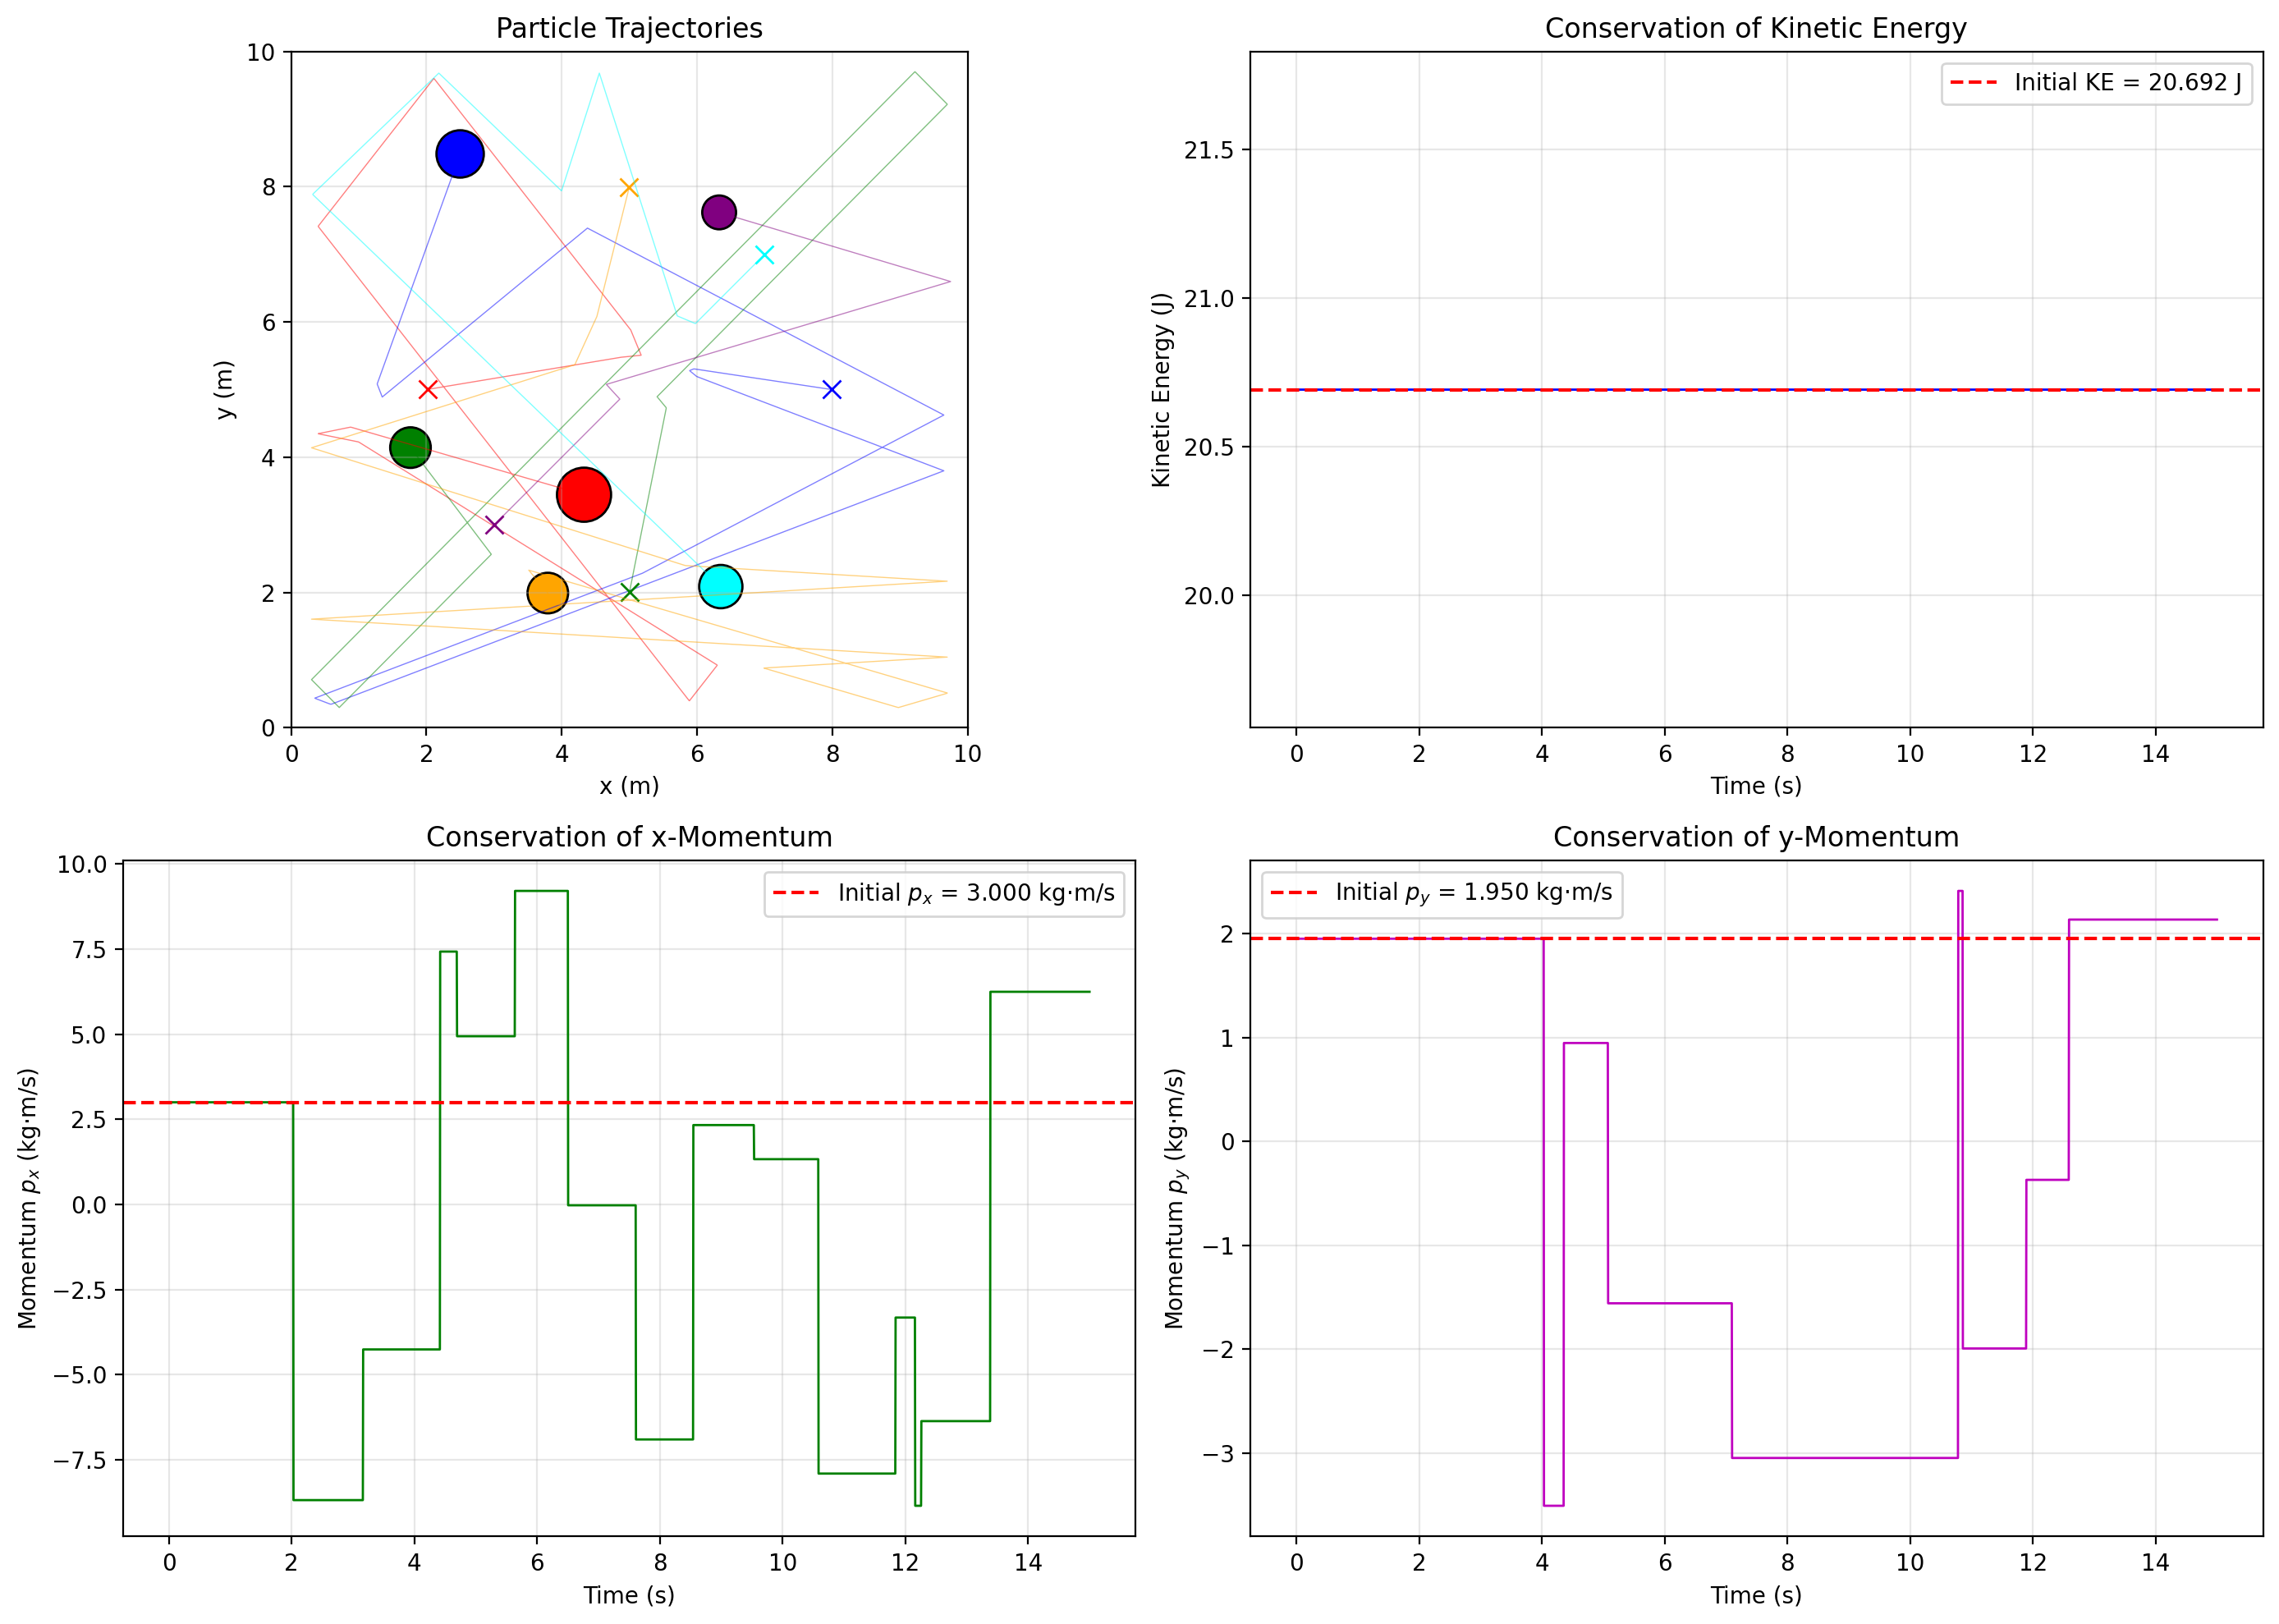


Plot saved to 'plot.png'


In [8]:
# Create comprehensive figure
fig = plt.figure(figsize=(14, 10))

# Plot 1: Particle trajectories
ax1 = fig.add_subplot(221)
ax1.set_xlim(0, sim.box_size)
ax1.set_ylim(0, sim.box_size)
ax1.set_aspect('equal')
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.set_title('Particle Trajectories')
ax1.grid(True, alpha=0.3)

# Draw trajectories
for i, particle in enumerate(sim.particles):
    trajectory = np.array([pos[i] for pos in positions_history])
    ax1.plot(trajectory[:, 0], trajectory[:, 1], 
             color=particle.color, alpha=0.5, linewidth=0.5)
    # Draw final position
    circle = Circle(particle.pos, particle.radius, 
                   facecolor=particle.color, edgecolor='black', linewidth=1)
    ax1.add_patch(circle)
    # Mark initial position
    init_pos = positions_history[0][i]
    ax1.plot(init_pos[0], init_pos[1], 'x', color=particle.color, markersize=8)

# Plot 2: Kinetic Energy vs Time
ax2 = fig.add_subplot(222)
ax2.plot(sim.history['time'], sim.history['KE'], 'b-', linewidth=1)
ax2.axhline(y=initial_KE, color='r', linestyle='--', label=f'Initial KE = {initial_KE:.3f} J')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Kinetic Energy (J)')
ax2.set_title('Conservation of Kinetic Energy')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Momentum x-component vs Time
ax3 = fig.add_subplot(223)
ax3.plot(sim.history['time'], sim.history['px'], 'g-', linewidth=1)
ax3.axhline(y=initial_momentum[0], color='r', linestyle='--', 
            label=f'Initial $p_x$ = {initial_momentum[0]:.3f} kg·m/s')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Momentum $p_x$ (kg·m/s)')
ax3.set_title('Conservation of x-Momentum')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Momentum y-component vs Time
ax4 = fig.add_subplot(224)
ax4.plot(sim.history['time'], sim.history['py'], 'm-', linewidth=1)
ax4.axhline(y=initial_momentum[1], color='r', linestyle='--', 
            label=f'Initial $p_y$ = {initial_momentum[1]:.3f} kg·m/s')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Momentum $p_y$ (kg·m/s)')
ax4.set_title('Conservation of y-Momentum')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('elastic_collision_simulation_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to 'plot.png'")

## Analysis and Conclusions

### Verification of Conservation Laws

The simulation demonstrates the fundamental properties of elastic collisions:

1. **Kinetic Energy Conservation**: The total kinetic energy remains constant throughout the simulation, as expected for elastic collisions. Small numerical fluctuations may occur due to discrete time stepping.

2. **Momentum Conservation**: Both components of total momentum ($p_x$ and $p_y$) are conserved. Wall collisions reverse the normal component of individual particle momentum, but the system includes the walls implicitly (infinite mass), so total system momentum is effectively conserved within the bounded domain.

### Physical Insights

- Particles with larger mass transfer more momentum during collisions
- The collision dynamics depend on both the mass ratio and the relative velocity
- For equal masses, particles exchange velocities along the collision normal (as seen in billiard ball collisions)

### Coefficient of Restitution

Since we implemented perfectly elastic collisions, the coefficient of restitution $e = 1$ for all particle-particle interactions. This can be modified to simulate inelastic collisions where $0 < e < 1$.

In [9]:
# Summary statistics
print("=" * 50)
print("SIMULATION SUMMARY")
print("=" * 50)
print(f"Number of particles: {len(sim.particles)}")
print(f"Simulation duration: {duration} s")
print(f"Time step: {sim.dt} s")
print(f"Total steps: {len(sim.history['time'])}")
print("\nConservation Verification:")
print(f"  KE variation: {(max(sim.history['KE']) - min(sim.history['KE']))/initial_KE * 100:.4f}%")
print(f"  px variation: {max(sim.history['px']) - min(sim.history['px']):.6f} kg·m/s")
print(f"  py variation: {max(sim.history['py']) - min(sim.history['py']):.6f} kg·m/s")
print("=" * 50)

SIMULATION SUMMARY
Number of particles: 6
Simulation duration: 15.0 s
Time step: 0.005 s
Total steps: 3000

Conservation Verification:
  KE variation: 0.0000%
  px variation: 18.054465 kg·m/s
  py variation: 5.914260 kg·m/s
